<a href="https://colab.research.google.com/github/kevin-1518/Dreamhouse/blob/main/Uplate_NLP_NEWS_categorie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"shengxuanhuangmike","key":"1195efed5a6c4012369c51a1f6cfca27"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rmisra/news-category-dataset

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-category-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
replace News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: News_Category_Dataset_v3.json  


In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_json('News_Category_Dataset_v3.json', lines=True)


In [ ]:
print(df.shape)

(209527, 6)


In [ ]:

df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [ ]:
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [ ]:
import pandas as pd


# Count the number of each category
category_counts = df['category'].value_counts()

# Halve the number of each category (round down)
half_counts = (category_counts // 2).astype(int)

# Obtain the top 10 categories with the highest number of items after halving.
top10_categories = half_counts.head(10)

print(top10_categories)

category
POLITICS          17801
WELLNESS           8972
ENTERTAINMENT      8681
TRAVEL             4950
STYLE & BEAUTY     4907
PARENTING          4395
HEALTHY LIVING     3347
QUEER VOICES       3173
FOOD & DRINK       3170
BUSINESS           2996
Name: count, dtype: int64


In [ ]:
# Count the number of each category and halve it.
category_counts = df['category'].value_counts()
half_counts = (category_counts // 2).astype(int)

# Take the first 10 categories after halving
top10_categories = half_counts.head(10)

# Initialise an empty DataFrame to store the results
filtered_df = pd.DataFrame()

# For each category, the number after sampling is halved.
for category, count in top10_categories.items():
    sampled = df[df['category'] == category].sample(n=count, random_state=42)
    filtered_df = pd.concat([filtered_df, sampled])

# Randomise order
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)



In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)                      # Remove HTML
    text = re.sub(r'http\S+|www\S+', '', text)             # Remove URL
    text = re.sub(r'[^a-z\s]', '', text)                   # Keep letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()               # Remove extra spaces
    return text

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:



filtered_df['combined_text'] = filtered_df['headline'].fillna('') + ' ' + filtered_df['short_description'].fillna('')

filtered_df['cleaned'] = filtered_df['combined_text'].apply(clean_text)
filtered_df['tokens'] = filtered_df['cleaned'].apply(tokenize)



filtered_df['joined_tokens'] = filtered_df['tokens'].apply(lambda x: ' '.join(x))
filtered_df.head()




,link,headline,category,short_description,authors,date,combined_text,cleaned,tokens,joined_tokens
0,https://www.huffingtonpost.com/entry/poor-food...,Why Some People In America's Salad Bowl Are Ea...,POLITICS,"Even in California's bountiful Central Valley,...",Joseph Erbentraut,2017-03-01,Why Some People In America's Salad Bowl Are Ea...,why some people in americas salad bowl are eat...,"[people, americas, salad, bowl, eating, junk, ...",people americas salad bowl eating junk food ev...
1,https://www.huffingtonpost.com/entry/your-favo...,Your Favorite Celebrities' Favorite Burgers an...,FOOD & DRINK,Where the stars go for burgers and pizza.,"The Daily Meal, Contributor\nAll things food a...",2013-08-07,Your Favorite Celebrities' Favorite Burgers an...,your favorite celebrities favorite burgers and...,"[favorite, celebrities, favorite, burgers, piz...",favorite celebrities favorite burgers pizza st...
2,https://www.huffingtonpost.com/entry/my-dog-sa...,My Dog Saved My Life: What It Means to Really ...,WELLNESS,"Yes, my best friend is sick -- but he's still ...","Shannon Kaiser, Contributor\nBest-Selling Auth...",2014-01-16,My Dog Saved My Life: What It Means to Really ...,my dog saved my life what it means to really l...,"[dog, saved, life, means, really, live, love, ...",dog saved life means really live love yes best...
3,https://www.huffingtonpost.com/entry/the-nordi...,The Nordic Countries Lead The World On LGBTQ E...,POLITICS,The Trump administration has already rolled ba...,Akbar Shahid Ahmed and Jennifer Bendery,2017-06-30,The Nordic Countries Lead The World On LGBTQ E...,the nordic countries lead the world on lgbtq e...,"[nordic, countries, lead, world, lgbtq, equali...",nordic countries lead world lgbtq equality her...
4,https://www.huffingtonpost.com/entry/butterfly...,Butterfly Time In Tanzania,TRAVEL,Mahale Mountains National Park is brimming wit...,"Eliza Deacon, Contributor\nContributor",2012-10-17,Butterfly Time In Tanzania Mahale Mountains Na...,butterfly time in tanzania mahale mountains na...,"[butterfly, time, tanzania, mahale, mountains,...",butterfly time tanzania mahale mountains natio...


#LSTM MODEL

In [ ]:
max_len = 100

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(filtered_df['joined_tokens'])
sequences = tokenizer.texts_to_sequences(filtered_df['joined_tokens'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(filtered_df['category'])
label_names = label_encoder.classes_.tolist()

num_classes = 10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded
)

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

vocab_size = 10000
embedding_dim = 64
max_len = 100
num_classes = 10


modelLSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_len,),
              embeddings_regularizer=l2(0.001)),
    tf.keras.layers.GaussianNoise(0.1),
    Dropout(0.4),

    Bidirectional(LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=l2(0.001),
        recurrent_regularizer=l2(0.001),
        activity_regularizer=l2(0.001)
    )),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])


modelLSTM.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

modelLSTM.build(input_shape=(None, max_len))
modelLSTM.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)


historyLSTM = modelLSTM.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

loss, accuracy = modelLSTM.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 100, 64)        │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,954 (2.73 MB)

 Trainable params: 714,954 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1092/1092 - 18s - 16ms/step - accuracy: 0.4385 - loss: 1.8977 - val_accuracy: 0.5559 - val_loss: 1.6177
Epoch 2/50
1092/1092 - 15s - 13ms/step - accuracy: 0.5319 - loss: 1.6842 - val_accuracy: 0.5882 - val_loss: 1.5136
Epoch 3/50
1092/1092 - 14s - 13ms/step - accuracy: 0.5635 - loss: 1.6256 - val_accuracy: 0.6198 - val_loss: 1.4649
Epoch 4/50
1092/1092 - 15s - 13ms/step - accuracy: 0.5824 - loss: 1.5803 - val_accuracy: 0.6401 - val_loss: 1.4252
Epoch 5/50
1092/1092 - 14s - 13ms/step - accuracy: 0.5997 - loss: 1.5615 - val_accuracy: 0.6689 - val_loss: 1.3844
Epoch 6/50
1092/1092 - 14s - 13ms/step - accuracy: 0.6230 - loss: 1.5274 - val_accuracy: 0.6983 - val_loss: 1.3394
Epoch 7/50
1092/1092 - 15s - 13ms/step - accuracy: 0.6411 - loss: 1.5089 - val_accuracy: 0.6987 - val_loss: 1.3331
Epoch 8/50
1092/1092 - 15s - 13ms/step - accuracy: 0.6495 - loss: 1.4888 - val_accuracy: 0.7007 - val_loss: 1.3334
Epoch 9/50
1092/1092 - 14s - 13ms/step - accuracy: 0.6554 - loss: 1.4715 - val_a

In [ ]:
"""
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
        dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    )))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuner_dir',
    project_name='news_classification_tuning'
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stop]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"LSTM Units: {best_hyperparameters.get('lstm_units')}")
print(f"Dropout: {best_hyperparameters.get('dropout')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Accuracy: {accuracy:.4f}")
"""


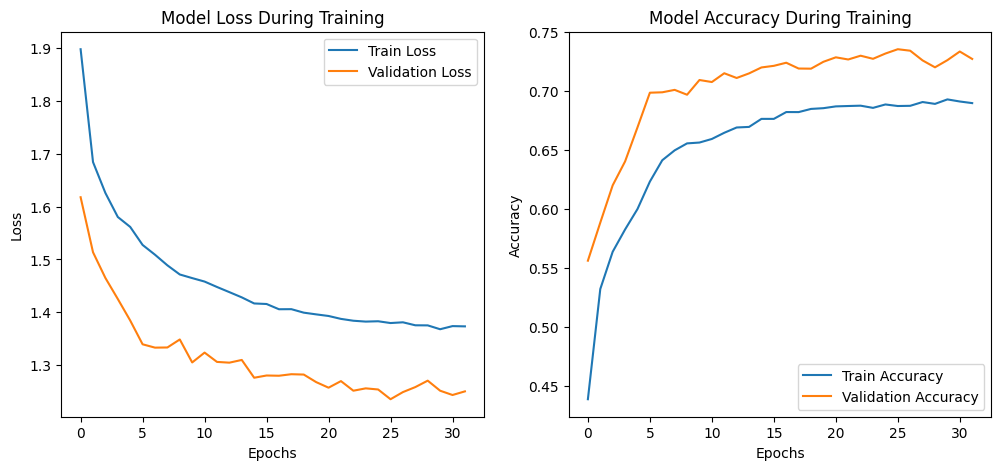

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historyLSTM.history['loss'], label='Train Loss')
plt.plot(historyLSTM.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyLSTM.history['accuracy'], label='Train Accuracy')
plt.plot(historyLSTM.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Classification Report:
                precision    recall  f1-score   support

      BUSINESS     0.5577    0.0323    0.0610       899
 ENTERTAINMENT     0.6937    0.7915    0.7394      2604
  FOOD & DRINK     0.7591    0.6793    0.7170       951
HEALTHY LIVING     0.5625    0.2331    0.3296      1004
     PARENTING     0.7586    0.6550    0.7030      1319
      POLITICS     0.8256    0.9052    0.8636      5340
  QUEER VOICES     0.8860    0.5389    0.6702       952
STYLE & BEAUTY     0.8601    0.7520    0.8025      1472
        TRAVEL     0.7981    0.7455    0.7709      1485
      WELLNESS     0.5743    0.8919    0.6987      2692

      accuracy                         0.7370     18718
     macro avg     0.7276    0.6225    0.6356     18718
  weighted avg     0.7396    0.7370    0.7146     18718



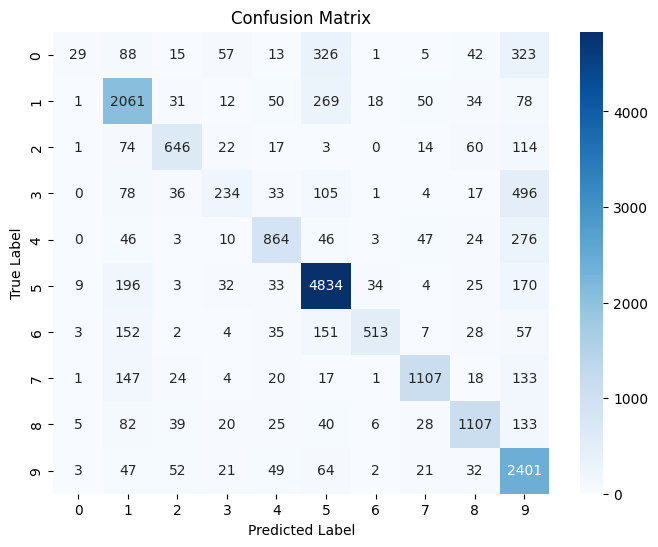

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


y_pred_probs = modelLSTM.predict(X_test)


y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)


report = classification_report(y_test, y_pred, digits=4,target_names=label_names)


print("Classification Report:")
print(report)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 64)   │    640,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 100, 64)   │          0 │ embedding_3[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 100, 32)   │      6,176 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 100, 32)   │      8,224 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 32)   │     10,272 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 96)        │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        970 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 665,642 (2.54 MB)

 Trainable params: 665,642 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2328 - loss: 2.2297
Epoch 1: val_loss improved from inf to 2.11251, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2329 - loss: 2.2295 - val_accuracy: 0.2838 - val_loss: 2.1125 - learning_rate: 1.0000e-04
Epoch 2/30
271/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2839 - loss: 2.1129
Epoch 2: val_loss improved from 2.11251 to 2.08245, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2839 - loss: 2.1128 - val_accuracy: 0.2838 - val_loss: 2.0825 - learning_rate: 1.0000e-04
Epoch 3/30
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2917 - loss: 2.0673
Epoch 3: val_loss improved from 2.08245 to 2.00159, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2917 - loss: 2.0671 - val_accuracy: 0.2838 - val_loss: 2.0016 - learning_rate: 1.0000e-04
Epoch 4/30
271/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2956 - loss: 1.9815
Epoch 4: val_loss improved from 2.00159 to 1.89070, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2957 - loss: 1.9811 - val_accuracy: 0.3359 - val_loss: 1.8907 - learning_rate: 1.0000e-04
Epoch 5/30
263/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3667 - loss: 1.8639
Epoch 5: val_loss improved from 1.89070 to 1.76689, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3678 - loss: 1.8626 - val_accuracy: 0.4871 - val_loss: 1.7669 - learning_rate: 1.0000e-04
Epoch 6/30
261/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4519 - loss: 1.7484
Epoch 6: val_loss improved from 1.76689 to 1.65957, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4527 - loss: 1.7471 - val_accuracy: 0.5188 - val_loss: 1.6596 - learning_rate: 1.0000e-04
Epoch 7/30
261/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5058 - loss: 1.6390
Epoch 7: val_loss improved from 1.65957 to 1.56620, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5060 - loss: 1.6383 - val_accuracy: 0.5425 - val_loss: 1.5662 - learning_rate: 1.0000e-04
Epoch 8/30
267/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5347 - loss: 1.5523
Epoch 8: val_loss improved from 1.56620 to 1.47684, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5348 - loss: 1.5518 - val_accuracy: 0.5631 - val_loss: 1.4768 - learning_rate: 1.0000e-04
Epoch 9/30
267/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5606 - loss: 1.4677
Epoch 9: val_loss improved from 1.47684 to 1.38719, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5607 - loss: 1.4671 - val_accuracy: 0.5889 - val_loss: 1.3872 - learning_rate: 1.0000e-04
Epoch 10/30
266/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5829 - loss: 1.3886
Epoch 10: val_loss improved from 1.38719 to 1.30071, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5832 - loss: 1.3878 - val_accuracy: 0.6132 - val_loss: 1.3007 - learning_rate: 1.0000e-04
Epoch 11/30
263/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6094 - loss: 1.2981
Epoch 11: val_loss improved from 1.30071 to 1.22274, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6096 - loss: 1.2974 - val_accuracy: 0.6389 - val_loss: 1.2227 - learning_rate: 1.0000e-04
Epoch 12/30
268/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6256 - loss: 1.2373
Epoch 12: val_loss improved from 1.22274 to 1.15553, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6258 - loss: 1.2367 - val_accuracy: 0.6586 - val_loss: 1.1555 - learning_rate: 1.0000e-04
Epoch 13/30
266/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6478 - loss: 1.1626
Epoch 13: val_loss improved from 1.15553 to 1.09928, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6479 - loss: 1.1622 - val_accuracy: 0.6741 - val_loss: 1.0993 - learning_rate: 1.0000e-04
Epoch 14/30
265/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6666 - loss: 1.1037
Epoch 14: val_loss improved from 1.09928 to 1.05286, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6667 - loss: 1.1034 - val_accuracy: 0.6849 - val_loss: 1.0529 - learning_rate: 1.0000e-04
Epoch 15/30
265/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6766 - loss: 1.0609
Epoch 15: val_loss improved from 1.05286 to 1.01368, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6767 - loss: 1.0604 - val_accuracy: 0.6961 - val_loss: 1.0137 - learning_rate: 1.0000e-04
Epoch 16/30
263/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6943 - loss: 1.0039
Epoch 16: val_loss improved from 1.01368 to 0.98067, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6943 - loss: 1.0038 - val_accuracy: 0.7083 - val_loss: 0.9807 - learning_rate: 1.0000e-04
Epoch 17/30
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7043 - loss: 0.9777
Epoch 17: val_loss improved from 0.98067 to 0.95235, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7043 - loss: 0.9776 - val_accuracy: 0.7163 - val_loss: 0.9523 - learning_rate: 1.0000e-04
Epoch 18/30
262/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7170 - loss: 0.9316
Epoch 18: val_loss improved from 0.95235 to 0.92790, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7170 - loss: 0.9316 - val_accuracy: 0.7230 - val_loss: 0.9279 - learning_rate: 1.0000e-04
Epoch 19/30
264/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7240 - loss: 0.9084
Epoch 19: val_loss improved from 0.92790 to 0.90615, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7240 - loss: 0.9083 - val_accuracy: 0.7280 - val_loss: 0.9062 - learning_rate: 1.0000e-04
Epoch 20/30
260/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7327 - loss: 0.8823
Epoch 20: val_loss improved from 0.90615 to 0.88813, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7328 - loss: 0.8820 - val_accuracy: 0.7338 - val_loss: 0.8881 - learning_rate: 1.0000e-04
Epoch 21/30
266/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7359 - loss: 0.8602
Epoch 21: val_loss improved from 0.88813 to 0.87203, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7361 - loss: 0.8599 - val_accuracy: 0.7377 - val_loss: 0.8720 - learning_rate: 1.0000e-04
Epoch 22/30
261/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7471 - loss: 0.8325
Epoch 22: val_loss improved from 0.87203 to 0.85820, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7470 - loss: 0.8326 - val_accuracy: 0.7436 - val_loss: 0.8582 - learning_rate: 1.0000e-04
Epoch 23/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7495 - loss: 0.8215
Epoch 23: val_loss improved from 0.85820 to 0.84533, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7495 - loss: 0.8214 - val_accuracy: 0.7448 - val_loss: 0.8453 - learning_rate: 1.0000e-04
Epoch 24/30
262/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7564 - loss: 0.7929
Epoch 24: val_loss improved from 0.84533 to 0.83489, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7565 - loss: 0.7930 - val_accuracy: 0.7475 - val_loss: 0.8349 - learning_rate: 1.0000e-04
Epoch 25/30
268/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7661 - loss: 0.7760
Epoch 25: val_loss improved from 0.83489 to 0.82631, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7661 - loss: 0.7759 - val_accuracy: 0.7497 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 26/30
263/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7701 - loss: 0.7521
Epoch 26: val_loss improved from 0.82631 to 0.81917, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7700 - loss: 0.7521 - val_accuracy: 0.7513 - val_loss: 0.8192 - learning_rate: 1.0000e-04
Epoch 27/30
260/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7782 - loss: 0.7332
Epoch 27: val_loss improved from 0.81917 to 0.81247, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7780 - loss: 0.7335 - val_accuracy: 0.7529 - val_loss: 0.8125 - learning_rate: 1.0000e-04
Epoch 28/30
270/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7810 - loss: 0.7158
Epoch 28: val_loss improved from 0.81247 to 0.80751, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7810 - loss: 0.7159 - val_accuracy: 0.7541 - val_loss: 0.8075 - learning_rate: 1.0000e-04
Epoch 29/30
271/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7815 - loss: 0.7095
Epoch 29: val_loss improved from 0.80751 to 0.80269, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7815 - loss: 0.7095 - val_accuracy: 0.7557 - val_loss: 0.8027 - learning_rate: 1.0000e-04
Epoch 30/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7914 - loss: 0.6924
Epoch 30: val_loss improved from 0.80269 to 0.79898, saving model to best_news_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7914 - loss: 0.6925 - val_accuracy: 0.7568 - val_loss: 0.7990 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7547 - loss: 0.8078
Test accuracy: 0.7569


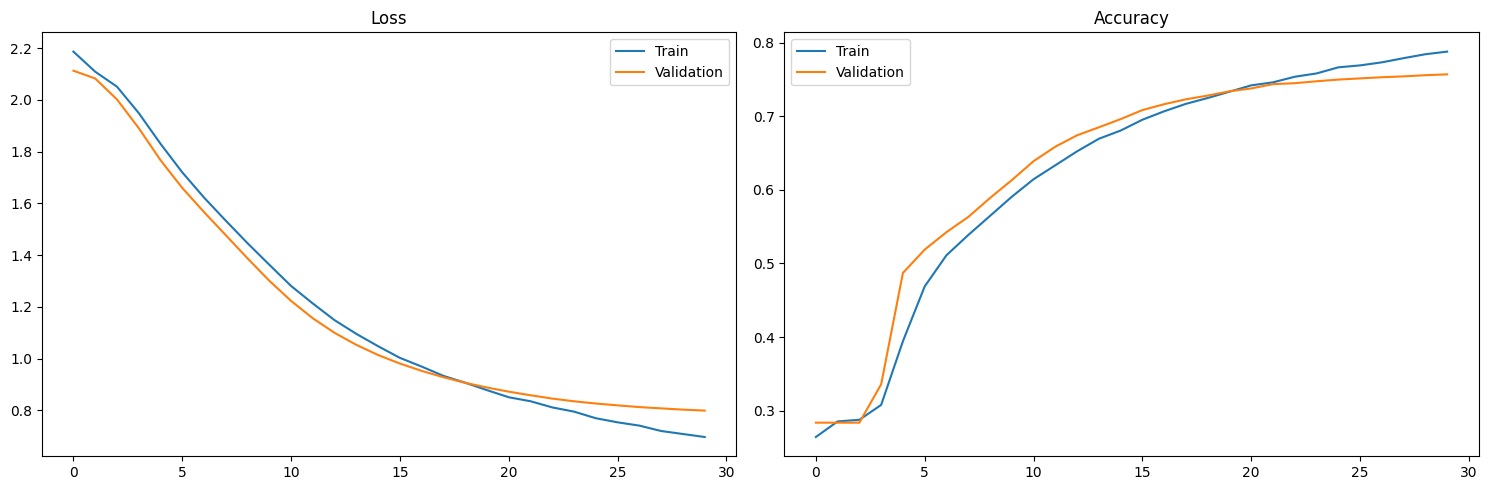

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.58      0.23      0.33       899
 ENTERTAINMENT       0.77      0.80      0.79      2604
  FOOD & DRINK       0.71      0.71      0.71       951
HEALTHY LIVING       0.60      0.01      0.02      1004
     PARENTING       0.73      0.72      0.72      1319
      POLITICS       0.84      0.92      0.88      5340
  QUEER VOICES       0.85      0.66      0.75       952
STYLE & BEAUTY       0.84      0.81      0.82      1472
        TRAVEL       0.78      0.79      0.79      1485
      WELLNESS       0.61      0.86      0.71      2692

      accuracy                           0.76     18718
     macro avg       0.73      0.65      0.65     18718
  weighted avg       0.75      0.76      0.73     18718



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Conv1D,
    Input, concatenate, SpatialDropout1D, GaussianNoise
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. DATA PREPROCESSING
# ---------------------
# Let's assume filtered_df contains 'joined_tokens' and 'category'

# Instead of doing simple train_test_split, create validation set as well
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(filtered_df['category'])
label_names = label_encoder.classes_.tolist()

num_classes = 10

# Constants
MAX_LEN = 100
VOCAB_SIZE = 10000
EMBEDDING_DIM = 64  # Reduced from 128
BATCH_SIZE = 128  # Much larger batch size
NUM_CLASSES = 10

def create_cnn_lstm_model():
    """Create a CNN-LSTM hybrid model (often works better for text classification)"""
    inputs = Input(shape=(MAX_LEN,))

    # Embedding layer
    x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN)(inputs)
    x = SpatialDropout1D(0.4)(x)

    # CNN layers with different filter sizes to capture different n-gram patterns
    conv1 = Conv1D(32, 3, padding='same', activation='relu')(x)
    conv2 = Conv1D(32, 4, padding='same', activation='relu')(x)
    conv3 = Conv1D(32, 5, padding='same', activation='relu')(x)

    # Max pooling
    max_pool1 = GlobalMaxPooling1D()(conv1)
    max_pool2 = GlobalMaxPooling1D()(conv2)
    max_pool3 = GlobalMaxPooling1D()(conv3)

    # Concatenate CNN outputs
    concat = concatenate([max_pool1, max_pool2, max_pool3])
    x = Dropout(0.5)(concat)

    # Output layer
    predictions = Dense(NUM_CLASSES, activation='softmax',
                        kernel_regularizer=l1_l2(l1=0.00001, l2=0.0001))(x)

    modelCNN = Model(inputs=inputs, outputs=predictions)
    modelCNN.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return modelCNN

# 4. TRAINING WITH K-FOLD CROSS VALIDATION
# ---------------------------------------
def train_with_kfold(X, y, model_creator, n_splits=5):
    """Train with stratified k-fold cross validation"""
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_histories = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"\nTraining fold {fold+1}/{n_splits}")

        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Create and compile model
        modelCNN = model_creator()

        # Callbacks
        early_stop = EarlyStopping(
            monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

        # Train model
        history = modelCNN.fit(
            X_train_fold, y_train_fold,
            epochs=30,
            batch_size=BATCH_SIZE,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stop, reduce_lr],
            verbose=2
        )

        fold_histories.append(history)
        fold_models.append(model)

    return fold_models, fold_histories

# 5. ENSEMBLE PREDICTION FUNCTION
# -----------------------------
def ensemble_predict(models, X):
    """Make predictions using an ensemble of models"""
    predictions = [modelCNN.predict(X, verbose=0) for modelCNN in models]
    # Average predictions from all models
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred


modelCNN = create_cnn_lstm_model()
model_creator = create_cnn_lstm_model

modelCNN.summary()

# Option 1: Simple Train/Val/Test Split
# ------------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_news_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Assuming X_train, y_train, X_val, y_val are defined
history = modelCNN.fit(
    X_train, y_train,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Use validation split if X_val is not defined
    # validation_data=(X_val, y_val),  # Uncomment if using separate validation set
    callbacks=callbacks,
    verbose=1
)

# 7. EVALUATION
# -----------
# Evaluate on test set
test_loss, test_acc = modelCNN.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report
y_pred = np.argmax(modelCNN.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

# 8. FEATURE IMPORTANCE ANALYSIS (OPTIONAL)
# ---------------------------------------
# This can help determine which words are most important for classification

def get_important_words(model, tokenizer, class_idx, top_n=20):
    """Analyze which input words are most important for a given class"""
    # Get weights from the embedding layer to the desired class output
    embedding_layer = model.layers[0]
    embedding_weights = embedding_layer.get_weights()[0]

    # Get weights from final dense layer
    dense_layer = model.layers[-1]
    dense_weights = dense_layer.get_weights()[0]

    # Get weights specifically for the target class
    class_weights = dense_weights[:, class_idx]

    # Compute importance scores
    word_importance = {}
    for word, idx in tokenizer.word_index.items():
        if idx < VOCAB_SIZE:  # Only consider words in vocabulary
            # Multiply embedding by class weights
            importance = np.dot(embedding_weights[idx], class_weights)
            word_importance[word] = importance

    # Get top words by importance
    top_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words

# Usage (uncomment to run):
# for i, class_name in enumerate(label_names):
#     print(f"\nTop words for class '{class_name}':")
#     top_words = get_important_words(model, tokenizer, i)
#     for word, importance in top_words:
#         print(f"  {word}: {importance:.4f}")

585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
                precision    recall  f1-score   support

      BUSINESS     0.5785    0.2336    0.3328       899
 ENTERTAINMENT     0.7735    0.8038    0.7883      2604
  FOOD & DRINK     0.7089    0.7066    0.7077       951
HEALTHY LIVING     0.6000    0.0120    0.0234      1004
     PARENTING     0.7256    0.7218    0.7237      1319
      POLITICS     0.8353    0.9219    0.8764      5340
  QUEER VOICES     0.8516    0.6628    0.7454       952
STYLE & BEAUTY     0.8360    0.8071    0.8213      1472
        TRAVEL     0.7844    0.7912    0.7878      1485
      WELLNESS     0.6058    0.8585    0.7103      2692

      accuracy                         0.7569     18718
     macro avg     0.7299    0.6519    0.6517     18718
  weighted avg     0.7514    0.7569    0.7311     18718



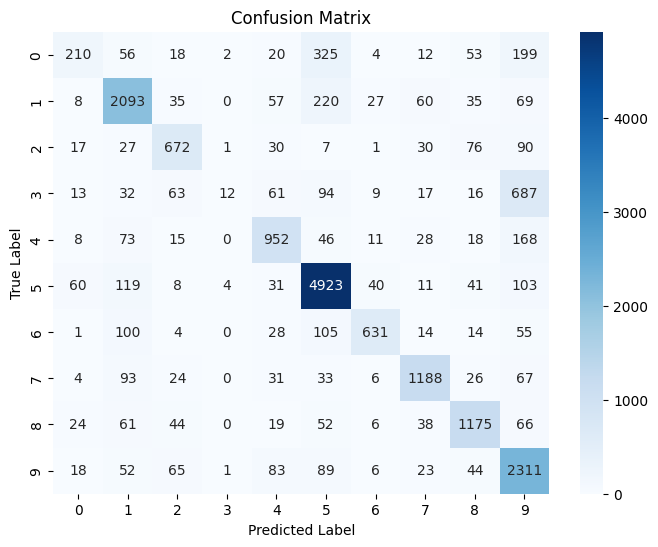

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


y_pred_probs = modelCNN.predict(X_test)


y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)


report = classification_report(y_test, y_pred, digits=4,target_names=label_names)


print("Classification Report:")
print(report)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_text_class(text_input):
    sequence = tokenizer.texts_to_sequences([text_input])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    prediction = modelLSTM.predict(padded)
    predicted_index = prediction.argmax(axis=-1)[0]

    predicted_category = label_encoder.inverse_transform([predicted_index])[0]

    print(f"Predict results:{predicted_category}（Lable number {predicted_index}）")
    print(f"categorical probability distribution：{prediction[0]}")

text = input("input your title：")
predict_text_class(text)



input your title：ten best pizza hub
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predict results:FOOD & DRINK（Lable number 2）
categorical probability distribution：[0.04624682 0.27183273 0.35296586 0.15288895 0.00168121 0.02110489
 0.01484094 0.00219859 0.13168976 0.00455023]




#Pretrained BERT

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

Dataset shape: (62392, 12)
Number of categories: 10
Categories: ['POLITICS', 'FOOD & DRINK', 'WELLNESS', 'TRAVEL', 'HEALTHY LIVING', 'QUEER VOICES', 'ENTERTAINMENT', 'STYLE & BEAUTY', 'PARENTING', 'BUSINESS']
Training set size: 49913
Test set size: 12479


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/49913 [00:00<?, ? examples/s]

Map:   0%|          | 0/12479 [00:00<?, ? examples/s]

<ipython-input-16-1c6f027dcf34>:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: miron12h (miron12h-university-of-technology-sydney) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,1.706300
200,1.005000
300,0.803600
400,0.717400
500,0.707700
600,0.668200
700,0.639700
800,0.639600
900,0.620900
1000,0.574100


Evaluation results: {'eval_loss': 0.49236607551574707, 'eval_accuracy': 0.8706627133584421, 'eval_runtime': 86.8262, 'eval_samples_per_second': 143.724, 'eval_steps_per_second': 8.983, 'epoch': 3.0}

Classification Report:
                precision    recall  f1-score   support

      POLITICS       0.93      0.93      0.93      3560
  FOOD & DRINK       0.88      0.89      0.88       634
      WELLNESS       0.79      0.87      0.83      1795
        TRAVEL       0.91      0.90      0.91       990
HEALTHY LIVING       0.68      0.52      0.59       669
  QUEER VOICES       0.84      0.81      0.82       635
 ENTERTAINMENT       0.90      0.91      0.91      1736
STYLE & BEAUTY       0.93      0.93      0.93       982
     PARENTING       0.85      0.84      0.85       879
      BUSINESS       0.74      0.73      0.74       599

      accuracy                           0.87     12479
     macro avg       0.85      0.83      0.84     12479
  weighted avg       0.87      0.87      0.87  

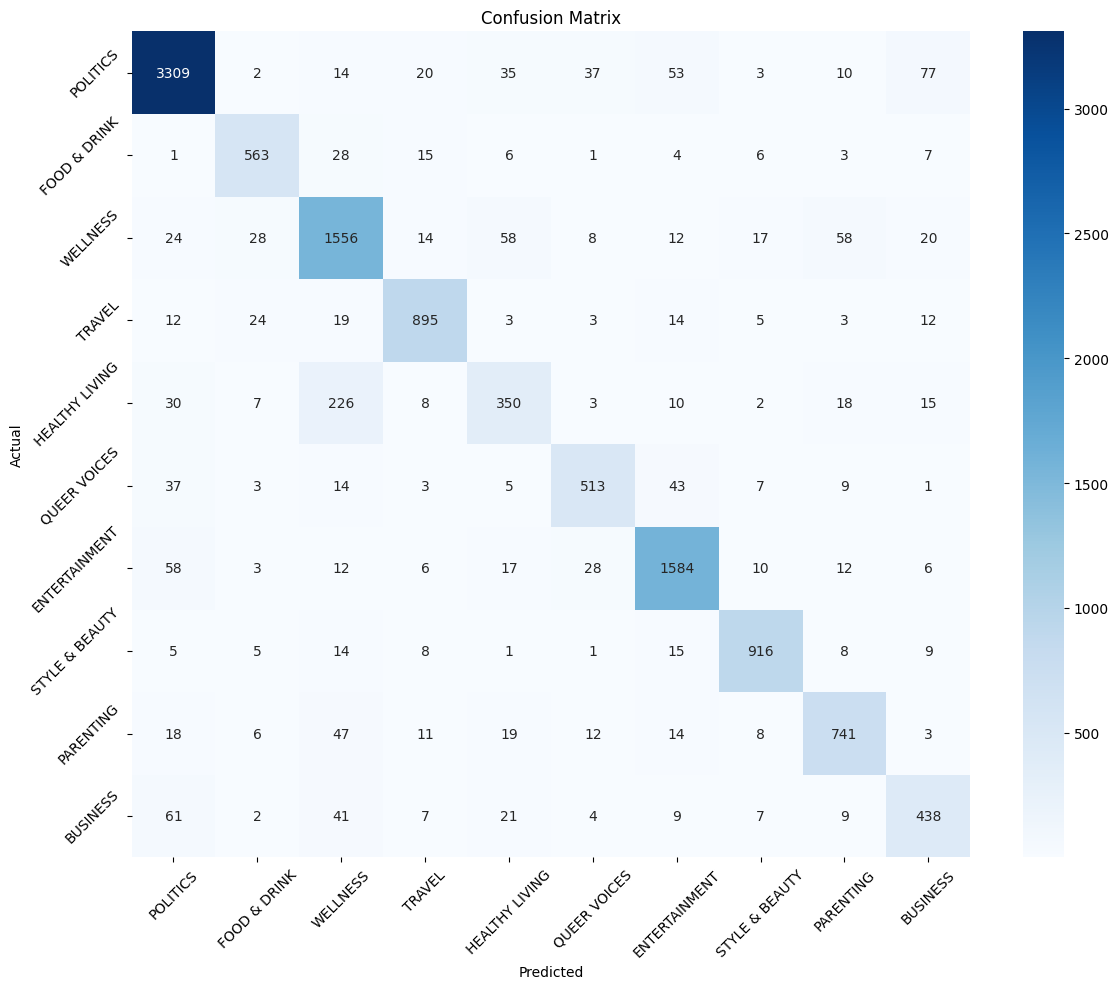

In [ ]:
filtered_df['text'] = filtered_df['headline'] + " " + filtered_df['short_description']


label_to_id = {label: i for i, label in enumerate(filtered_df['category'].unique())}
id_to_label = {i: label for label, i in label_to_id.items()}
filtered_df['label'] = filtered_df['category'].map(label_to_id)

print(f"Dataset shape: {filtered_df.shape}")
print(f"Number of categories: {len(label_to_id)}")
print(f"Categories: {list(label_to_id.keys())}")


train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42, stratify=filtered_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_to_id),
    id2label=id_to_label,
    label2id=label_to_id
)


def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


trainer.train()


results = trainer.evaluate()
print("Evaluation results:", results)


predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)


print("\nClassification Report:")
print(classification_report(test_df['label'], predicted_labels, target_names=label_to_id.keys()))


plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_df['label'], predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_id.keys(),
            yticklabels=label_to_id.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()